In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sys import stdout
from time import sleep

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_parquet('data/train.parquet')
test = pd.read_parquet('data/test.parquet')
sample_sub = pd.read_csv('data/sample_submission.csv')

train.head(10)

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
5,59504,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[0.08, 0.88, 1.46, 0.59, -0.97, -0.41, 0.78, -...",0.0
6,49554,"[2016-04-01, 2016-05-01, 2016-06-01, 2016-07-0...","[1.05, -0.28, 1.09, -0.69, 1.26, 1.79, 1.38, -...",0.0
7,58344,"[2016-12-01, 2017-01-01, 2017-02-01, 2017-03-0...","[-0.36, -0.45, -0.4, -0.4, -0.45, -0.45, -0.45...",0.0
8,87449,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.92, 4.11, 3.39, -1.17, -0.79, 2.15, -0.22, ...",1.0
9,43415,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-0.86, -0.05, -0.35, -0.67, -0.25, -0.8, -0.6...",1.0


In [3]:
sample_sub.head(10)

,id,score
0,6125.0,0.757097
1,26781.0,0.346173
2,13333.0,0.431305
3,53218.0,0.847472
4,84204.0,0.065298
5,69997.0,0.689232
6,99301.0,0.025703
7,4361.0,0.461261
8,46607.0,0.293316
9,29836.0,0.233549


---

Посмотрим, какого размера данные и есть ли в них пропуски

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20000 non-null  int64 
 1   dates   20000 non-null  object
 2   values  20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


Пропусков не найдено, но есть интересная деталь. Поскольку столбцы с датами и значениями содержат массивы, то можно реструктурировать данные и создать альтернативную таблицу, где под каждую дату можно выделить отдельный признак. Одна строка такой таблицы будет выглядеть примерно так.

In [6]:
one = pd.DataFrame(
    index = ['1'],
    columns = train.loc[0, 'dates'], 
    data = train.loc[0, 'values'].reshape(1, -1)
)

one

,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,...,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01
1,-1.86,0.79,1.4,0.15,0.0,-1.24,-1.46,3.49,1.2,1.93,...,-1.67,-1.47,0.52,-0.77,1.2,-0.28,0.89,0.35,-0.51,-0.57


Потом в таблицу будут добавляться все новые значения. Так будут выглядеть на графике первые 2 строки.

<AxesSubplot: >

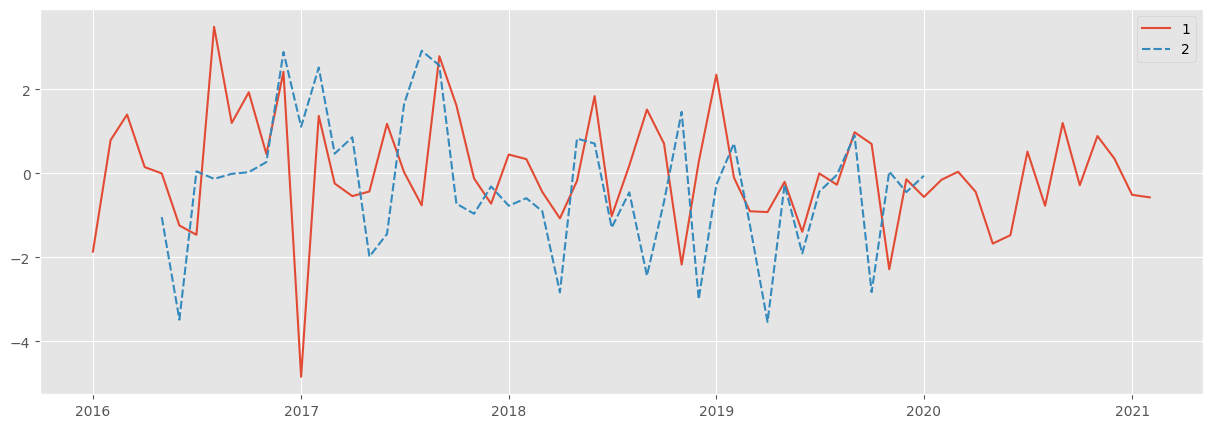

In [7]:
two = pd.DataFrame(
    index = ['2'],
    columns = train.loc[1, 'dates'], 
    data = train.loc[1, 'values'].reshape(1, -1)
)

three = pd.concat([one, two])

sns.lineplot(three.T)

Как видим, первая и вторая строки имеют неодинаковую длину, так как наблюдения начинаются и заканчиваются в разное время. Следовательно второй временной ряд нужно дополнить новыми наблюдениями, то есть спрогнозировать их.

In [8]:
data = pd.concat([train, test], ignore_index=True)
lens = data['dates'].apply(lambda x: len(x)).sort_values().index[[0, -1]]

shortest = data.loc[lens[0], 'dates']
longest = data.loc[lens[1], 'dates']

len(shortest), len(longest)

(36, 97)

In [9]:
earliest = data['dates'].apply(lambda x: min(x)).sort_values().iloc[0]
latest = data['dates'].apply(lambda x: max(x)).sort_values().iloc[-1]

earliest, latest

(datetime.date(2016, 1, 1), datetime.date(2024, 1, 1))

In [10]:
def restructure_data(data):
    newdf = pd.DataFrame()
    
    for i in data.index: 
        newrow = pd.DataFrame(
            index=[i],
            columns=data.loc[i, 'dates'], 
            data=data.loc[i, 'values'].reshape(1, -1))
        
        newdf = pd.concat([newdf, newrow])
        
        stdout.write(f"\r{i}")
        stdout.flush()
        sleep(0.0001)
    
    return newdf


test['label'] = -1
data = pd.concat([train, test], ignore_index=True)

re_data = restructure_data(data) 

re_data

99999

,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,...,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01
0,-1.86,0.79,1.40,0.15,0.00,-1.24,-1.46,3.49,1.20,1.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,-1.04,-3.48,0.05,-0.13,-0.01,0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.33,0.58,1.10,-0.56,-0.95,-0.61,-0.70,-1.35,-0.77,-0.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.31,0.50,-0.54,0.95,0.65,0.83,-1.55,-0.28,-1.24,0.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,NaN,NaN,3.01,-0.58,1.55,0.48,-0.35,1.93,3.86,2.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99996,0.66,1.30,2.78,-0.25,-1.97,-0.55,-1.08,-1.55,-2.62,0.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


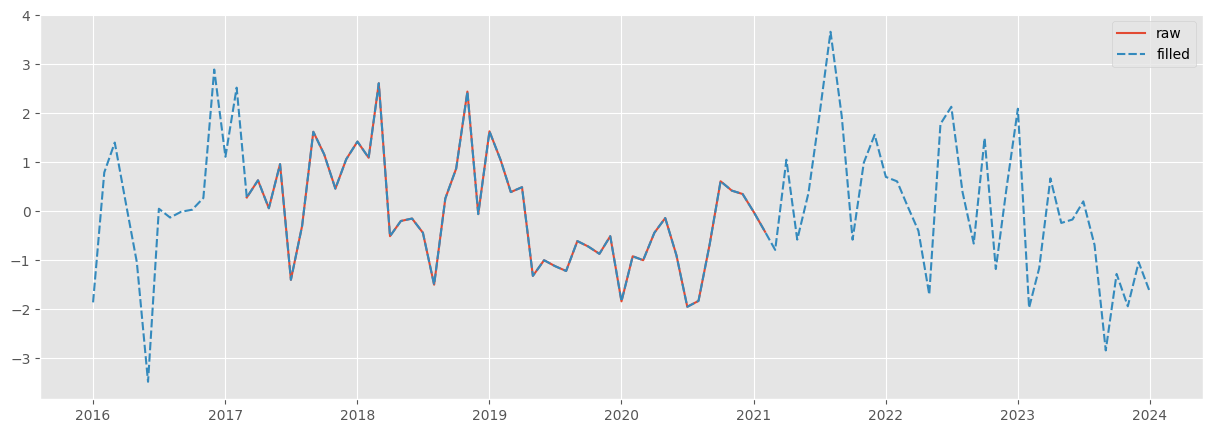

In [11]:
row2 = pd.DataFrame({
    'raw': re_data.iloc[2], 
    'filled': re_data.ffill().bfill().iloc[2]
})

sns.lineplot(row2)
plt.show()

In [12]:
re_data = re_data.ffill().bfill() 
re_data['label'] = data['label']

re_train = re_data[re_data['label'] >= 0]
re_test = re_data[re_data['label'] < 0].drop('label', axis=1)

re_train

,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,...,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,label
0,-1.86,0.79,1.40,0.15,0.00,-1.24,-1.46,3.49,1.20,1.93,...,-0.24,-0.17,0.20,-0.69,-2.84,-1.28,-1.94,-1.04,-1.65,0.0
1,-1.86,0.79,1.40,0.15,-1.04,-3.48,0.05,-0.13,-0.01,0.03,...,-0.24,-0.17,0.20,-0.69,-2.84,-1.28,-1.94,-1.04,-1.65,1.0
2,-1.86,0.79,1.40,0.15,-1.04,-3.48,0.05,-0.13,-0.01,0.03,...,-0.24,-0.17,0.20,-0.69,-2.84,-1.28,-1.94,-1.04,-1.65,0.0
3,-0.33,0.58,1.10,-0.56,-0.95,-0.61,-0.70,-1.35,-0.77,-0.94,...,-0.24,-0.17,0.20,-0.69,-2.84,-1.28,-1.94,-1.04,-1.65,0.0
4,1.31,0.50,-0.54,0.95,0.65,0.83,-1.55,-0.28,-1.24,0.51,...,-0.24,-0.17,0.20,-0.69,-2.84,-1.28,-1.94,-1.04,-1.65,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,2.17,0.46,0.64,-0.06,0.47,-0.30,-1.64,-0.12,-0.10,-0.01,...,1.25,-1.59,-0.83,0.07,0.73,1.19,0.61,-0.30,-1.21,0.0
79996,2.17,0.46,0.64,-0.06,0.47,-0.30,-0.35,-1.31,0.11,1.46,...,1.25,-1.59,-0.83,0.07,0.73,1.19,0.61,-0.30,-1.21,1.0
79997,2.17,0.46,-0.78,-2.27,-1.85,-0.67,-1.20,-2.02,0.12,-1.39,...,1.25,-1.59,-0.83,0.07,0.73,1.19,0.61,-0.30,-1.21,0.0
79998,2.17,-2.29,-2.85,0.92,-0.83,-1.75,-1.81,-2.29,1.67,0.97,...,1.25,-1.59,-0.83,0.07,0.73,1.19,0.61,-0.30,-1.21,0.0


In [13]:
re_train['label'].value_counts()

label
0.0    57820
1.0    22180
Name: count, dtype: int64

In [14]:
y = re_train.pop('label')

X_train, X_valid, y_train, y_valid = train_test_split(
    re_train, y, 
    test_size=0.2, 
    random_state=33, 
    stratify=y
)

data_pool = X_train, X_valid, y_train, y_valid

X_train

,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,...,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01
60501,0.30,-0.53,0.42,-0.05,0.86,-0.41,-0.29,-0.96,0.35,-0.09,...,0.100000,-0.000000,0.190000,0.180000,-0.310000,0.620000,1.580000,1.330000,0.120000,2.150000
70373,1.41,1.52,-0.73,-1.05,-0.20,-1.03,-2.42,-2.22,-2.25,-0.11,...,-1.740000,-1.320000,-1.230000,-0.290000,-0.690000,-0.910000,0.230000,-1.140000,-2.300000,1.760000
8659,-1.51,1.22,2.23,0.94,0.73,1.21,2.07,0.95,0.74,1.49,...,1.110000,-0.990000,0.200000,0.440000,0.610000,0.900000,0.360000,-0.330000,-0.510000,0.290000
16468,-0.32,-1.52,0.31,-0.59,2.87,2.21,1.56,1.45,0.79,-0.31,...,0.830000,-1.840000,-1.750000,-0.070000,0.810000,0.990000,2.150000,-1.162512,-1.892512,-2.802512
41799,-1.20,0.17,-1.27,1.89,0.49,0.21,-2.00,3.17,3.13,-0.33,...,-1.720000,-1.380000,0.210000,-0.350000,1.450000,-1.646825,-0.806825,0.760000,-0.670000,-0.770000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40337,-1.02,-1.35,-1.40,0.67,-0.07,-0.54,1.01,-1.01,0.01,0.36,...,-1.360000,-0.470000,-2.360000,-1.200000,-2.160000,-1.035090,-1.265090,-2.005090,0.590000,0.600000
40613,0.46,0.01,1.97,2.13,0.26,-0.01,-0.18,0.42,0.81,1.18,...,-0.843443,0.396557,-0.473443,-2.153443,-1.613443,-1.313443,-1.333443,-0.703443,-2.430611,0.770000
58299,-0.73,-0.82,0.93,0.49,-0.32,-0.76,0.64,-1.87,0.67,1.65,...,0.080000,-0.370000,-1.730000,-1.030000,-0.990000,-1.580000,0.700000,-1.160000,-0.560000,1.910000
73061,0.50,0.49,-1.18,0.26,0.91,1.86,-0.88,0.41,0.68,-0.86,...,0.040000,1.210000,-1.150000,-1.250000,-1.660000,-0.222000,-0.480000,-0.620000,-0.800000,1.590000


In [19]:
def calc_rocauc(model, X, y):
    proba = model.predict_proba(X)[:, 1]
    rocauc = roc_auc_score(y, proba)
    
    return round(rocauc, 2)


def estimate_model(model, pool=data_pool):
    X_train, X_valid, y_train, y_valid = pool
    model.fit(X_train, y_train)

    rocauc_train = calc_rocauc(model, X_train, y_train)
    rocauc_valid = calc_rocauc(model, X_valid, y_valid)

    print('Train ROC AUC: ', rocauc_train)
    print('Valid ROC AUC: ', rocauc_valid)
    
    
baseline = LogisticRegression()

estimate_model(baseline)

Train ROC AUC:  0.67
Valid ROC AUC:  0.67


In [21]:
forest = RandomForestClassifier(random_state=33)

estimate_model(forest)

Train ROC AUC:  1.0
Valid ROC AUC:  0.68
